 <!DOCTYPE html>
<html>
<head>
  <title>ESI data generation </title>
</head>
<body>

<h1>Data generation for the CNN </h1>
<p> Here we show the data generated for the CNN training. Generation is based on the growth model. We define ten parameters to generate growth rates and theta criticals for the growth model. Based on the growth rate and the theta criticals we calculate the thickness and roughness evolution of the thin layer. Finally XRR curves are generated based on the thickness and roughness.</p>
<p></p>

</body>
</html> 

In [1]:
from numpy import exp, array, insert
from math import log, sqrt, e
%matplotlib inline
import numpy as np
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import CheckButtons, Cursor

from tqdm import tqdm

print('Module imports finished')

###############################################################################
###############      Trofimov-model for layer coverages         ###############
###############################################################################

def trofimov(X, t, *args):
    """
    X: list of differential equations to solve
    t: independent variable
    args: Xc, R123
        Xc: list of theta criticals
        R123 = R1,R2,R3,R: growth rates for different layers
    """
    
    def Xi(Theta, ThetaC):
        """ calculate Xi_n for Theta_n and ThetaC_n """
        
        if Theta > ThetaC:
            if Theta >= 1: return 1 #catch rounding errors, math domain error
            if Theta <= 0: return 0
            if ThetaC >= 1: return 1 #catch rounding errors, math domain error
            if ThetaC <= 0: return 0
            expo1 = sqrt(-log(1-Theta))
            expo2 = sqrt(-log(1-ThetaC))
            return 1 - exp(-(expo1-expo2)*(expo1-expo2))
        else: return 0
    
    Xc, R123 = args
    R1, R2, R3, R = R123
    N = len(Xc)

    # Rate equations for different rates for the first four ML
    eqn1 = 0
    if X[0] < 0.99999999:
        eqn1 = R1 * (1-X[0]) + R2 * (X[0] - Xi(X[0],Xc[0]))

    eqn2 = R2 * (Xi(X[0],Xc[0]) - X[1]) + R * (X[1] - Xi(X[1],Xc[1]))

    eqn3 = R3 * (Xi(X[1],Xc[1]) - X[2]) + R * (X[2] - Xi(X[2],Xc[2]))

    eqn = [R*(Xi(X[n-2],Xc[n-2]) - Xi(X[n-1],Xc[n-1])) for n in range(4,N+1)]
    
    return array([eqn1, eqn2, eqn3] + eqn)


###############################################################################
###############     Functions for calculations      ###############
###############################################################################

def calc_all(t, R123, ThetaC):
    """ Calculate coverages, thickness, roughness, reflectivity """
    
    X0 = [0]*N                          # layer-coverages for t=0

    X = integrate.odeint(trofimov, X0, t, args=(ThetaC,R123), mxstep=2000)[:]
    ###Davka
    for ii in range(80):
        for jj in range(35):
            if X[ii,jj]>=1:
                X[ii,jj]=1
    coverages = np.transpose(X)     # Coverages in a.u.
    thickness = sum(coverages)      # Total film thickness in a.u.
    # Film roughness in [ML]
    roughness = np.sqrt(abs(sum([(coverages[i] - coverages[i+1])
                              *(i+1 - thickness)**2 for i in range(N-1)])))
    


    return X, coverages, thickness, roughness

Module imports finished


100%|██████████| 100/100 [00:00<00:00, 8843.89it/s]


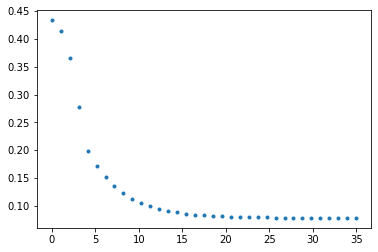

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


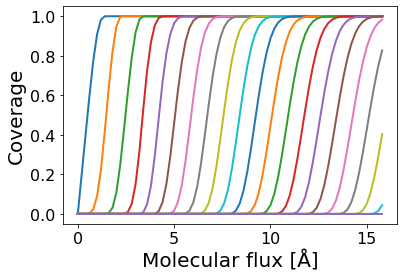

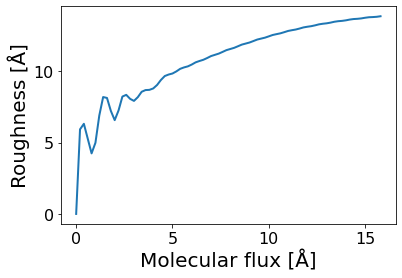

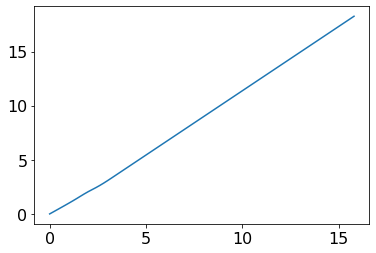

In [2]:
###############################################################################
###############     Functions for calculations      ###############
###############################################################################

#number of layers growing  
roughness_m=np.zeros((80,0))
thickness_m=np.zeros((80,0))
label=[]


N=35
datasetSize = 100

G1 = np.random.uniform(0.5, 1.1, size=(datasetSize)) #0.959
G2 = np.random.uniform(0.5, 1.1, size=(datasetSize)) #0.695
G3 = np.random.uniform(0.7, 1.2, size=(datasetSize)) #0.85
G4 = np.random.uniform(0.9, 1.7, size=(datasetSize)) #1.09

t = np.arange(0, 16, 0.2).tolist()

x = np.linspace(0, N, N)

a = np.random.uniform(0.2, 0.6, size=(datasetSize)) #max starting value 0.28
b = np.random.uniform(0.05, 0.7, size=(datasetSize)) #exp decay 0.59
c = np.random.uniform(0.11, 0.4, size=(datasetSize)) #crossover 0.134
d = np.random.uniform(-7, 0, size=(datasetSize)) #shift -5.75
g = np.random.uniform(0.002, 0.105, size=(datasetSize)) #convergation 0.028


SLDd = np.random.uniform(8.5, 18.5, size=(datasetSize)) #was at 4 and 24 9.6
SLDdat = SLDd*1e14

z1 = np.zeros((N,0))

for i in tqdm(range(datasetSize)):
#     if a[i]<c[i]:
#         c[i]
    f = 0
    z = a[i]*(((0.5*np.tanh(-0.5*(x+d[i]))+0.5))/((0.5*np.tanh(-0.5*d[i])+0.5)))
    for j in range (N):
        if z[j] > c[i]:
            z[j] = z[j]
            f = j
        else:    
            z[j] = (c[i]-g[i])*e**(-b[i]*x[j-f])+g[i]
        
    z = z.reshape(N,1)
    z1 = np.append(z1, z, axis=1)
    

plt.plot(x,z,'.')
plt.show()
#multiple grow example
for i in tqdm(range(datasetSize)):
    gr =[G1[i], G2[i], G3[i], G4[i]]
    thetacrit = z1[:,i]
    out = calc_all(t,gr,thetacrit)
    Roug = out[3].reshape(80,1)
    thick = out[2].reshape(80,1)
    thickness_m = np.append(thickness_m, thick, axis=1)
    roughness_m = np.append(roughness_m, Roug, axis=1)
    lab = G1[i], G2[i], G3[i], G4[i], a[i], b[i], c[i], d[i], g[i], SLDdat[i]
    label.append(lab)
    
#plt.figure(figsize=(8, 6), dpi=1200)
plt.rcParams['font.size'] = '16'
for i in range (N):
    plt.plot(t, out[0][:,i], linewidth=2)
plt.xlabel('Molecular flux [Å]', fontsize=20)
plt.ylabel('Coverage', fontsize=20)
plt.show()


#plt.figure(figsize=(8, 6), dpi=1200)
plt.plot(t, out[3]*16.6, linewidth=2)
plt.xlabel('Molecular flux [Å]', fontsize=20)
plt.ylabel('Roughness [Å]', fontsize=20)
plt.show()

plt.plot(t, out[2])
plt.show()



In [3]:
print(thickness_m.shape)
print(roughness_m.shape)

print(max(thickness_m[79,:])*16.6)
print(min(thickness_m[79,:])*16.6)
print(max(roughness_m[79,:])*16.6)
print(min(roughness_m[79,:])*16.6)


(80, 100)
(80, 100)
415.57791853063594
235.2982628585349
39.13066474653424
10.299468095355921


In [4]:
import numpy as np
from data_handling import make_reflectivity_curves
import matplotlib.pyplot as plt



In [5]:
q_values = np.linspace(0.01, 0.14, 109)
q_values = q_values * 1e10 


n_samples = 1
training_data_output = np.zeros([len(q_values), 0])


In [6]:
th1 = np.random.uniform(20, 80, size=(1, datasetSize))
rg1 = np.random.uniform(10, 40, size=(1, datasetSize))
rgb = np.random.uniform(15, 50, size=(1, datasetSize))

SLD1 = np.random.uniform(80, 300, size=(1, datasetSize))
SLDb = np.random.uniform(100, 250, size=(1, datasetSize))
labels = np.zeros([9, 0])




100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


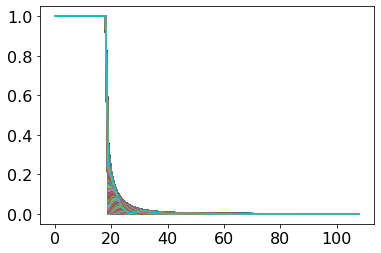

In [7]:
from numpy import append
for i in tqdm(range (datasetSize)):
    
    
    for x in range (0,80):
        
        thickness = np.array([thickness_m[x,i]*16.6*1e-10, 10*1e-10, 0*1e-10]) ###(Layer,oxide,bulk)       
        repetitions = n_samples
        thicknesses = np.tile(thickness, (repetitions, 1))
        
        roughness = np.array([roughness_m[x,i]*16.6*1e-10, 2.5*1e-10, 1*1e-10])
        repetitions = n_samples
        roughnesses = np.tile(roughness, (repetitions, 1))

        
        SLD = np.array([SLDdat[i], 1.900*1e15, 2.0*1e+15]) ###(oxide,bulk)
        repetitions = n_samples
        SLDs = np.tile(SLD, (repetitions, 1))
        training_reflectivity = make_reflectivity_curves(
                q_values, thicknesses, roughnesses, SLDs, n_samples)
        
        labelsx = append(thickness, roughness)
        labelsx = append(labelsx, SLD)
        labelsx = np.expand_dims(labelsx, axis=1)
        labels = append(labels, labelsx, axis=1)

        training_data_output = append(training_data_output, training_reflectivity, axis=1) 

In [8]:
roughness_m.shape

(80, 100)

In [9]:
print(training_data_output.shape)
arr = np.array(label)

(109, 8000)


In [10]:
#training_data_output.dump("training_dataGM9.dat")
#arr.dump("label_Theta9.dat")

In [11]:
print(arr.shape)

(100, 10)


In [12]:
print(min(a), max(a))
print(a.shape)

0.20226007107832078 0.5930920158989584
(100,)
